# Impulse responses, Local projections vs. SVAR 

Notebook on how local projection (LP) and srtuctural vector autoregression (SVAR) impulse responses are the same.

Examples inspired by research piece Plagborg-Møller & Wolf (2020): *Local projections and VARs estimate the same impulse responses*.

Notebook by @VilleEcon.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as sm_form
from statsmodels.stats.moment_helpers import corr2cov
np.random.seed(5000)
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
library(dagitty)

## Simulate data from a known data generating process

We assume the true data genrating process (DGP) is

$$
\begin{align*}
Y_{t} & = \beta_{1} Y_{t-1} + \beta_{2} Y_{t-2} + \gamma u_{t}
\end{align*}
$$

where

$
\begin{align*}
Y_t = \begin{bmatrix} Y_{1,t} \\ Y_{2,t} \\ Y_{3,t} \end{bmatrix}
\end{align*}
$, $
\begin{align*}
u_t = \begin{bmatrix} u_{1,t} \\ u_{2,t} \\ u_{3,t} \end{bmatrix}
\end{align*}
$, $
\begin{align*}
\beta_1 = \begin{bmatrix} 0.50 & 0.75 & -0.25 \\ -0.15 & 0.85 & 0 \\ 0 & 0 & 0.50 \end{bmatrix}
\end{align*}
$, $
\begin{align*}
\beta_2 = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0.30 & 0 \\ 0 & -0.40 & 0 \end{bmatrix}
\end{align*}
$, and $
\begin{align*}
\gamma = \begin{bmatrix} 1 & 0 & 0 \\ 1 & 1 & 0 \\ 1 & 0 & 1 \end{bmatrix}
\end{align*}
$.

$u_t$ is multivariate normal with assumed means 0 and standard deviations 1, and further assumed that shocks are not correlated, meaning correlation matrix

$
\begin{align*}
\mathbf{\Sigma}_u = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}
\end{align*}
$.

Time-series directed acyclic graph of the DGP looks like this:

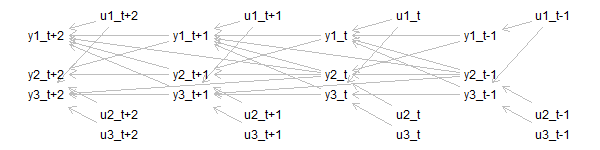

In [3]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,2"]
    "y2_t+2" [pos="0,4"]
    "u1_t+2" [pos="1,1"]
    "u2_t+2" [pos="1,6"]
    "y1_t+1" [pos="2,2"]
    "y2_t+1" [pos="2,4"]
    "u1_t+1" [pos="3,1"]
    "u2_t+1" [pos="3,6"]
    "y1_t"   [pos="4,2"]
    "y2_t"   [pos="4,4"]
    "u1_t"   [pos="5,1"]
    "u2_t"   [pos="5,6"]
    "y1_t-1" [pos="6,2"]
    "y2_t-1" [pos="6,4"]
    "u1_t-1" [pos="7,1"]
    "u2_t-1" [pos="7,6"]
    "y3_t+2" [pos="0,5"]
    "u3_t+2" [pos="1,7"]
    "y3_t+1" [pos="2,5"]
    "u3_t+1" [pos="3,7"]      
    "y3_t"   [pos="4,5"]
    "u3_t"   [pos="5,7"]      
    "y3_t-1" [pos="6,5"]
    "u3_t-1" [pos="7,7"]      
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y3_t+2" <- "y3_t+1" <- "y3_t" <- "y3_t-1"
    "y2_t+1" -> "y1_t+2" <- "y3_t+1"
    "y2_t" -> "y1_t+1" <- "y3_t"
    "y2_t-1" -> "y1_t" <- "y3_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t" <- "y1_t-1"
    "y1_t+2" <- "y2_t" -> "y3_t+2"
    "y1_t+1" <- "y2_t-1" -> "y3_t+1"
    "y1_t+2" <- "u1_t+2" -> "y3_t+2"; "y3_t+2" <- "u1_t+2"
    "y1_t+1" <- "u1_t+1" -> "y3_t+1"; "y3_t+1" <- "u1_t+1"
    "y1_t" <- "u1_t" -> "y3_t"; "y3_t" <- "u1_t"
    "y1_t-1" <- "u1_t-1" -> "y3_t-1"; "y3_t-1" <- "u1_t-1"
    "y2_t+2" <- "u2_t+2"; "y2_t+1" <- "u2_t+1"; "y2_t" <- "u2_t"; "y2_t-1" <- "u2_t-1"
    "y3_t+2" <- "u3_t+2"; "y3_t+1" <- "u3_t+1"; "y3_t" <- "u3_t"; "y3_t-1" <- "u3_t-1"    

}')
plot(g)

,y1,y2,y3
0,1.327334,3.110259,3.183105
1,1.745176,0.957998,1.411857


,y1,y2,y3
998,0.147953,2.668153,0.621568
999,3.256378,5.478365,1.113196


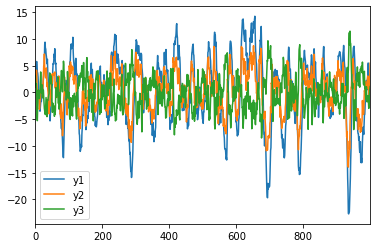

In [4]:
# Number of observations and intial state
no_obs = 1000
no_presample = 200
initial_state = np.array([[0, 0, 0], [0, 0, 0]])

# Generate array of u's
u_means = [0 ,0, 0]
u_stds = [1, 1, 1]
corrmat = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 1, 1]
]
covmat = corr2cov(corrmat, u_stds)
u_array = np.random.multivariate_normal(
    mean=u_means,
    cov=covmat,
    size=no_obs+no_presample-2
)

# Allocate array for data, with initial values plugged in
data_array = np.empty([no_obs+no_presample, 3])
data_array[:] = np.nan
data_array[0:2, :] = initial_state

# coefficient arrays
beta1 = np.array([
       [0.50, 0.75, -0.25], 
       [-0.15, 0.85, 0],
       [0, 0, 0.50],       
])
beta2 = np.array([
       [0, 0, 0], 
       [0, 0.30, 0],
       [0, -0.40, 0],       
])
gamma = np.array([
       [1, 0, 0], 
       [1, 1, 0],
       [1, 0, 1],       
])

# Simulate data
for i in range(2, no_obs+no_presample):
    data_array[i, :] = (np.matmul(beta1, data_array[i-1, :, np.newaxis]) + 
                        np.matmul(beta2, data_array[i-2, :, np.newaxis]) + 
                        np.matmul(gamma, u_array[i-2, :, np.newaxis])).T

df = pd.DataFrame(data_array[no_presample:, :], columns=["y1", "y2", "y3"])
_ = df.plot()
display(df.head(2))
display(df.tail(2))

## Get SVAR impulse reponses

We fit following SVAR model to the DGP. Our SVAR model is very good in the sense that it correctly captures the features of DGP (linearity, Gaussianity). Further, we identify the model using recursive ordering, which also nests the true underlying structure of exogenous process $u_t$.

We fit VAR(3) model

$$
\begin{align*}
Y_{t} & = A_{1} Y_{t-1} + A_{2} Y_{t-2} + A_{3} Y_{t-3} + \epsilon_{t}
\end{align*}
$$

Corresponding SVAR model

$$
\begin{align*}
B_0 Y_{t} & = B_{1} Y_{t-1} + B_{2} Y_{t-2} + B_{3} Y_{t-3} + \omega_{t}
\end{align*}
$$

with recursive identification

$$
\begin{align*}
\begin{bmatrix} \epsilon_{1,t} \\ \epsilon_{2,t} \\ \epsilon_{3,t} \end{bmatrix} = \begin{bmatrix} ? & 0 & 0 \\ ? & ? & 0 \\ ? & ? & ? \end{bmatrix} \ \begin{bmatrix} \omega_{1,t} \\ \omega_{2,t} \\ \omega_{3,t} \end{bmatrix}
\end{align*}
$$.

That is, for identification we assume following contemporanenous relations:

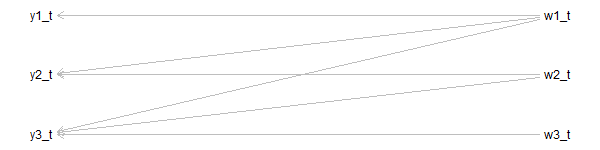

In [5]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t"   [pos="4,0"]
    "y2_t"   [pos="4,1"]
    "w1_t"   [pos="5,0"]
    "w2_t"   [pos="5,1"]
    "y3_t"   [pos="4,2"]
    "w3_t"   [pos="5,2"]
    "y1_t" <- "w1_t" -> "y2_t"; "w1_t" -> "y3_t" 
    "y2_t" <- "w2_t" -> "y3_t"
    "y3_t" <- "w3_t"
}')
plot(g)

In [6]:
# VAR
no_lags = 3
model1_var = sm.tsa.VAR(df.copy())
res1_var = model1_var.fit(maxlags=no_lags)

# SVAR
D = np.asarray([
    ["E", 0, 0],
    ["E", "E", 0],
    ["E", "E", "E"],
])
model1_svar = sm.tsa.SVAR(df.copy(), svar_type='A', A=D)
res1_svar = model1_svar.fit(maxlags=no_lags)
irf1_svar = res1_svar.irf(15)

# Put structural shocks into data frame; make sure time index matches as series is of length len(df)-no_lags
resid1_structural = pd.DataFrame(np.matmul(res1_svar.A, res1_svar.resid.T).T, columns=df.columns, index=list(range(no_lags, len(res1_svar.resid)+no_lags)))

In [7]:
res1_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, Oct, 2020
Time:                     18:59:45
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.181792
Nobs:                     997.000    HQIC:                 0.0903071
Log likelihood:          -4231.10    FPE:                    1.03480
AIC:                    0.0342063    Det(Omega_mle):         1.00428
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.022500         0.030762           -0.731           0.465
L1.y1         0.561765         0.047660           11.787           0.000
L1.y2         0.756601         0.028021           27.001           0.000
L1.y3        -0.277134

In [8]:
print("Residual correlation matrix")
display(pd.DataFrame(np.corrcoef(res1_svar.resid, rowvar=False)))
print("-"*40)
print("Structural shock correlation matrix")
display(pd.DataFrame(np.corrcoef(resid1_structural, rowvar=False)))

Residual correlation matrix


,0,1,2
0,1.000000,0.628659,0.715560
1,0.628659,1.000000,0.664235
2,0.715560,0.664235,1.000000


----------------------------------------
Structural shock correlation matrix


,0,1,2
0,1.000000e+00,-2.282624e-07,3.485568e-07
1,-2.282624e-07,1.000000e+00,-1.703639e-07
2,3.485568e-07,-1.703639e-07,1.000000e+00


## Get local projection impulse responses

Following Plagborg-Møller & Wolf (2020) section 3.2, Example 1 with recursive identification, we can also derive impulse responses using local projections. They key is to respect the same assumptions about contemporanoues causality in local projections (i.e. simple OLS regression) that we used in identifying the SVAR.

Here we estimate the impulse responses for each of the three variables on impulse in $y_2$ and with horizon $h=15$ as in SVAR. Local projection with corresponding assumptions from SVAR reads

$$y_{t+h} = \mu_{y_2, h} + \theta_{y_2, h} \ y_{2,t} + \lambda_{y_2, h} \ y_{1,t} + \sum_{l=1}^{3} \delta_{y_2, h, l} \ y_{y-l} + \xi_{y_2, h, t} $$

That is we assume following contemporaneous relations as shown below (compare to corresponsing SVAR case). This means that when we want to find out the impact of impulse in $y_{2,t}$ (i.e. in SVAR context impulse coming from shock variable $\omega_{2,t}$) to $y_{i,t+h} \ , \ i=1,2,3$ we shall NOT control for $y_{3,t}$ as this would block the assumed causal path $y_{2,t} \rightarrow y_{3,t} \rightarrow \cdots \rightarrow y_{i,t+h}$. In turn, one should control for $y_{1,t}$ as the effect of impulses in $y_{1,t}$ affect $y_{i,t+h}$ besides mediated through $y_{2,t}$.

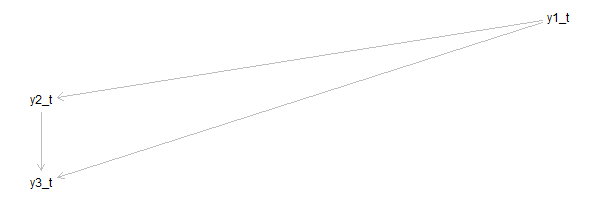

In [9]:
%%R -h 200 -w 600
g = dagitty( 'dag {
    "y1_t"   [pos="1,0"]
    "y2_t"   [pos="0,1"]
    "y3_t"   [pos="0,2"]
    "y2_t"<- "y1_t" -> "y3_t"
    "y2_t" -> "y3_t"
}')
plot(g)

In [10]:
# Prepare data for local projections
horizon = 15
gg = df.copy()
for p in [1, 2, 3]:
    for col in ["y1", "y2", "y3"]:
        gg[col + "_lag" + str(p)] = gg[col].shift(p)
for h in range(0,horizon+1):
    for col in ["y1", "y2", "y3"]:
        gg[col + "_lead" + str(h)] = gg[col].shift(-h)
gg.dropna(inplace=True)

In [11]:
# Run local projections
lp = pd.DataFrame()
for col in ["y1", "y2", "y3"]:
    mycoefs = []
    for h in range(horizon+1):
        ols_res = sm_form.ols(
            formula=col+"_lead"+str(h)+" ~ y2 + y1 + y1_lag1 + y1_lag2 + y1_lag3 + y2_lag1 + y2_lag2 + y2_lag3 + y3_lag1 + y3_lag2 + y3_lag3", data=gg.copy()
        ).fit()
        mycoefs.append(ols_res.params["y2"])
    lp[col] = mycoefs

## Compare impulse responses

Compare impulse responses $y_{2,t} \rightarrow y_{1, t+h}$, $y_{2,t} \rightarrow y_{2, t+h}$, and $y_{2,t} \rightarrow y_{3, t+h}$ between SVAR and LP. Impulse responses deviate slightly dye to finite lag length *p* (see the paper for more information).

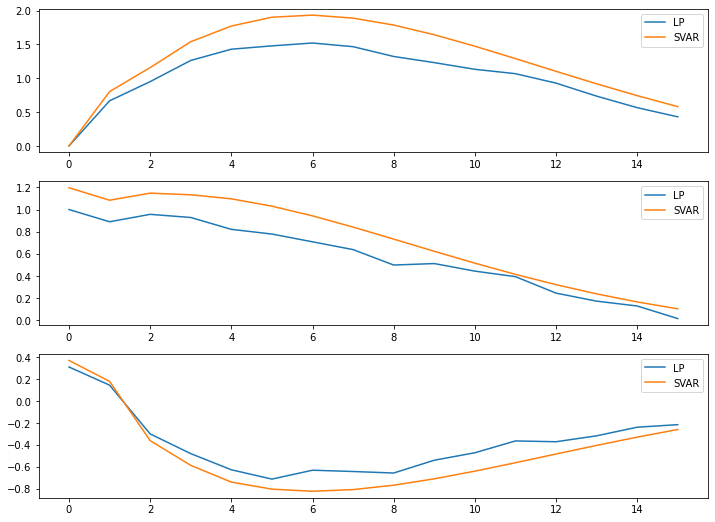

In [12]:
fig = plt.figure(figsize=(12, 9))
for count, endog_var in zip([1, 2, 3], ["y1", "y2", "y3"]):
    ax = fig.add_subplot(3, 1, count)
    _ = ax.plot(lp[endog_var], label="LP")
    _ = ax.plot(irf1_svar.svar_irfs[:, count-1, 1], label="SVAR")
    ax.legend()

Impulse responses from SVAR for checking.

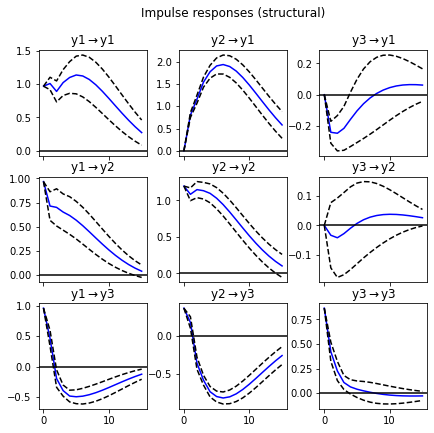

In [13]:
fig = irf1_svar.plot()
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(6, 6)
plt.subplots_adjust(top=0.88, wspace=0.3)